#Importing Required Libraries


In [53]:
import numpy as np 
import pandas as pd 
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

#Fetching Dataset

In [ ]:
!wget https://www.dropbox.com/s/i891luuq4anvwfj/ODIR-5K.zip?dl=0
!wget https://www.dropbox.com/s/xeqw1f7dikd627f/prpimg.zip?dl=0
!wget https://www.dropbox.com/s/t74scpz88dlopxg/full_df.csv.zip?dl=0

--2022-05-04 17:41:53--  https://www.dropbox.com/s/i891luuq4anvwfj/ODIR-5K.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/i891luuq4anvwfj/ODIR-5K.zip [following]
--2022-05-04 17:41:53--  https://www.dropbox.com/s/raw/i891luuq4anvwfj/ODIR-5K.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd8543cf477bb7fb1fff144c5e9.dl.dropboxusercontent.com/cd/0/inline/BkpsfHk8siXHmGkKbd0Nd-4-tKRxtJDbxBbkdVEOTLPt1utYUuweEzun6hGRq7jlCc1Q_rWlMy380Yaz4da3s3gShPFmILvnzVQaiHXjbmBLk_IVxFYZxEIoODqscCXKKgY6ODc9Cmet0zEBKXyUWQpdT-hWj2NY8A2ZOM9yG47g2Q/file# [following]
--2022-05-04 17:41:54--  https://ucd8543cf477bb7fb1fff144c5e9.dl.dropboxusercontent.com/cd/0/inline/BkpsfHk8siXHmGkKbd0Nd-4-tKRxtJDbxBbkdVEOTLPt1utYUuweEzun6hGRq7jlC

#Unzipping the Zipped files

In [ ]:
!unzip "/content/ODIR-5K.zip?dl=0"
!unzip "/content/prpimg.zip?dl=0"
!unzip "/content/full_df.csv.zip?dl=0"

Streaming output truncated to the last 5000 lines.
  inflating: preprocessed_images/217_left.jpg  
  inflating: preprocessed_images/217_right.jpg  
  inflating: preprocessed_images/2180_left.jpg  
  inflating: preprocessed_images/2180_right.jpg  
  inflating: preprocessed_images/2181_left.jpg  
  inflating: preprocessed_images/2181_right.jpg  
  inflating: preprocessed_images/2182_left.jpg  
  inflating: preprocessed_images/2182_right.jpg  
  inflating: preprocessed_images/2183_left.jpg  
  inflating: preprocessed_images/2183_right.jpg  
  inflating: preprocessed_images/2184_left.jpg  
  inflating: preprocessed_images/2184_right.jpg  
  inflating: preprocessed_images/2185_left.jpg  
  inflating: preprocessed_images/2185_right.jpg  
  inflating: preprocessed_images/2187_left.jpg  
  inflating: preprocessed_images/2187_right.jpg  
  inflating: preprocessed_images/2189_left.jpg  
  inflating: preprocessed_images/2189_right.jpg  
  inflating: preprocessed_images/218_left.jpg  
  inflating:

#Loading Data in Dataframe

In [54]:
df = pd.read_csv("/content/full_df.csv")
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


#Extracting Cataract & Normal information from the Dataset

In [55]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [56]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [57]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:15]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg', '553_left.jpg', '560_left.jpg',
       '594_left.jpg', '611_left.jpg', '625_left.jpg'], dtype=object)

In [58]:
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [59]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


#Normal Images

In [60]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [61]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [62]:
print(len(cataract),len(normal))

594 500


#Creating Dataset from images

In [63]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/content/preprocessed_images/"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset
        

In [64]:
dataset = create_dataset(cataract,1)

100%|██████████| 594/594 [00:02<00:00, 205.00it/s]


In [65]:
len(dataset)

588

In [66]:
dataset = create_dataset(normal,0)

100%|██████████| 500/500 [00:02<00:00, 193.54it/s]


In [67]:
len(dataset)

1088

#Some images

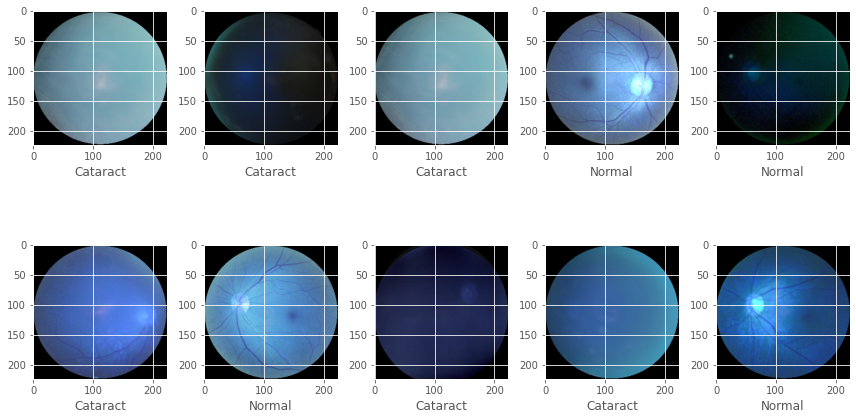

In [68]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

#Dividing dataset into x(features) & y(target)

In [69]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [70]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

#Creating Model

In [71]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

In [72]:
for layer in vgg.layers:
    layer.trainable = False

In [73]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [74]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [75]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [76]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [77]:
history = model.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_test,y_test),verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/15
28/28 [==============================] - 13s 433ms/step - loss: 1.7738 - accuracy: 0.8770 - val_loss: 1.4277 - val_accuracy: 0.9220
Epoch 2/15
28/28 [==============================] - 12s 421ms/step - loss: 0.5101 - accuracy: 0.9552 - val_loss: 0.7154 - val_accuracy: 0.9083
Epoch 3/15
28/28 [==============================] - 12s 421ms/step - loss: 0.1249 - accuracy: 0.9828 - val_loss: 0.4376 - val_accuracy: 0.9450
Epoch 4/15
28/28 [==============================] - 12s 419ms/step - loss: 0.0198 - accuracy: 0.9966 - val_loss: 0.5060 - val_accuracy: 0.9450
Epoch 5/15
28/28 [==============================] - 12s 420ms/step - loss: 0.0078 - accuracy: 0.9966 - val_loss: 0.5166 - val_accuracy: 0.9541
Epoch 6/15
28/28 [==============================] - 12s 419ms/step - loss: 5.0670e-04 - accuracy: 1.0000 - val_loss: 0.4780 - val_accuracy: 0.9495
Epoch 7/15
28/28 [==============================] - 12s 419ms/step - loss: 2.6148e-04 - accuracy: 1.0000 - val_loss: 0.4886 - val_accuracy

In [78]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 [==============================] - 2s 334ms/step - loss: 0.4855 - accuracy: 0.9495
loss: 0.48546692728996277
Accuracy: 0.9495412707328796


In [79]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = (model.predict(x_test) > 0.5).astype("int32")

In [80]:
model.save("eyedisease.h5")

#Model Accuracy

In [81]:
accuracy_score(y_test,y_pred)

0.9495412844036697

In [82]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94        97
           1       0.94      0.97      0.96       121

    accuracy                           0.95       218
   macro avg       0.95      0.95      0.95       218
weighted avg       0.95      0.95      0.95       218



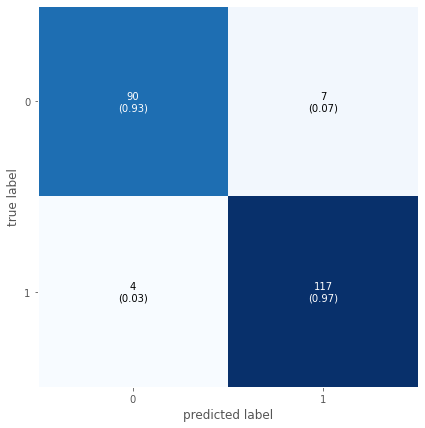

In [86]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),show_normed = True);

#Learning Curve

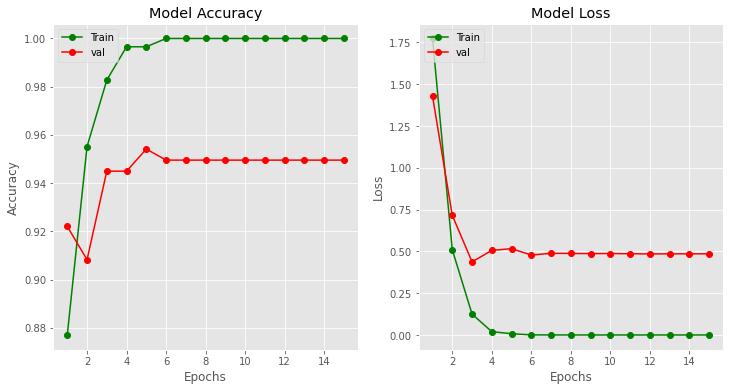

In [87]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,16)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

#Prediction

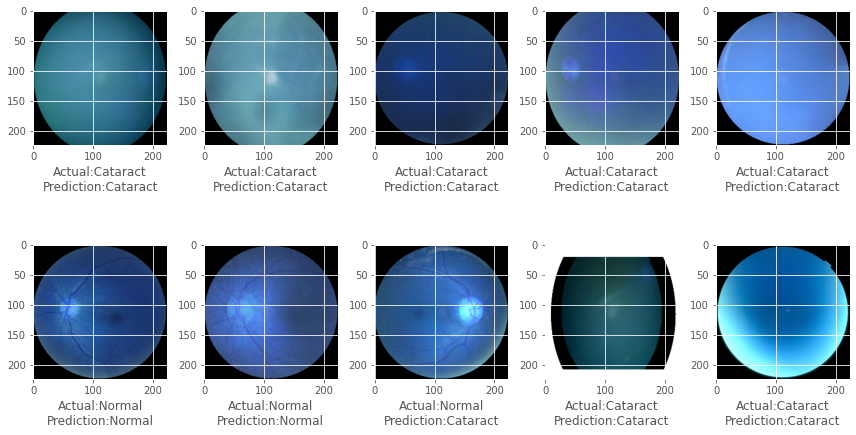

In [88]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"      
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"   
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 